# Stream temperature

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
from natsort import natsorted
import datetime
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

In [3]:
# Import and format observed data (2003-2007 runoff)

input_dir = config.velma_data
results_dir = config.data_path.parents[0] / 'results' / 'calibration' / 'subzero_water_balance' / 'ellsworth_baseline_03_07_21_19'

runoff_start = pd.to_datetime('01-01-2003')
runoff_end = pd.to_datetime('12-31-2007')
nse_start = pd.to_datetime('01-01-2004')
nse_end = pd.to_datetime('12-31-2007')

start = pd.to_datetime('01-01-2004')
end = pd.to_datetime('12-31-2007')

# Simulated runoff
velma_results = pd.read_csv(results_dir / 'DailyResults.csv')
# Format datetime of results
jday_pad = velma_results['Day'].apply(lambda x: str(x).zfill(3))
str_year = velma_results['Year'].apply(lambda x: str(x))
velma_results['year_jday'] = str_year + jday_pad
velma_results.index = pd.to_datetime(velma_results['year_jday'], format='%Y%j')
velma_results = velma_results[(velma_results.index >= start) & (velma_results.index <= end)]
    
# Stream temperature observations
streamtemp_path = config.data_path / 'hydrology' / 'ellsworth' / 'wa_ecy_gauge' / 'stream_temp' / 'ells_streamtemp_2003_2008.csv'
streamtemp_obs = pd.read_csv(streamtemp_path, usecols=['date', 'water_temp'], parse_dates=True, index_col=0)
streamtemp_obs['doy'], streamtemp_obs['year'] = streamtemp_obs.index.dayofyear, streamtemp_obs.index.year
streamtemp_obs = streamtemp_obs[(streamtemp_obs.index >= start) & (streamtemp_obs.index <= end)]

# Stream temperature quality codes
streamtemp_path = config.data_path  / 'hydrology' / 'ellsworth' / 'wa_ecy_gauge' / 'stream_temp' / 'ells_streamtemp_2003_2008.csv'
stream_temp_quality = pd.read_csv(streamtemp_path, usecols=['date', 'quality'], parse_dates=True, index_col=0)
stream_temp_quality['doy'], stream_temp_quality['year'] = stream_temp_quality.index.dayofyear, stream_temp_quality.index.year
stream_temp_quality = stream_temp_quality[(stream_temp_quality.index >= start) & (stream_temp_quality.index <= end)]

# Runoff observations
runoff_path = input_dir / 'runoff' / 'ellsworth_Q_2003_2007_dummy.csv'
runoff_obs = pd.read_csv(runoff_path, names=['runoff_obs'])
runoff_obs.index = pd.date_range(runoff_start, runoff_end)
runoff_obs['doy'], runoff_obs['year'] = runoff_obs.index.dayofyear, runoff_obs.index.year
runoff_obs = runoff_obs[(runoff_obs.index >= start) & (runoff_obs.index <= end)]

# Runoff quality codes
flow_path = config.streamflow
quality = pd.read_csv(flow_path, usecols=['Date', 'Quality'], parse_dates=True, index_col=0)
quality = quality[(quality.index >= start) & (quality.index <= end)]

# Precipitation
precip_path = input_dir / 'precip' / 'PRISM_gauge_avg_ppt_2003_2019.csv'
forcing_start = pd.to_datetime('01-01-2003')
forcing_end = pd.to_datetime('12-31-2019')                     
precip = pd.read_csv(precip_path, names=['precip'])
precip.index = pd.date_range(forcing_start, forcing_end)
precip['doy'], precip['year'] = precip.index.dayofyear, precip.index.year
precip = precip[(precip.index >= start) & (precip.index <= end)]

# Air temperature
temp_path = input_dir / 'temp' / 'ellsworth_temp_2003_2019.csv'
temp = pd.read_csv(temp_path, names=['temp'])
temp.index = pd.date_range(forcing_start, forcing_end)
temp['doy'], temp['year'] = temp.index.dayofyear, temp.index.year
temp = temp[(temp.index >= start) & (temp.index <= end)]

In [4]:
# Get stream temperature from cell writer files

# Get paths
cell_paths = []
for file in os.listdir(results_dir):
    if file.startswith('Cell_'):
        cell_paths.append(file)

nodes = []
for path in cell_paths:
    nodes.append(path.split('_')[-1])

cell_paths_sorted = [x for _,x in natsorted(zip(nodes,cell_paths))]

cell_results = []
for path in cell_paths_sorted:
    cell_result = pd.read_csv(results_dir / path)
    jday_pad = cell_result['Jday'].apply(lambda x: str(x).zfill(3))
    str_year = cell_result['Year'].apply(lambda x: str(x))
    cell_result['date'] = str_year + jday_pad
    rng = pd.to_datetime(cell_result['date'], format='%Y%j')
    cell_result.index = rng
    cell_result = cell_result[(cell_result.index >= start) & (cell_result.index <= end)]
    cell_results.append(cell_result)

# coords = pd.read_csv(results_dir.parents[0] / 'cell_writer_nodes_coords.txt', delimiter=',')

In [5]:
# Convert to pivot tables

cell_pivots = []
for df in cell_results:
    piv = pd.pivot_table(df, index=['Jday'], columns=['Year'], 
                         values='Water_Surface_Temperature(degrees_C)', dropna=False)
    cell_pivots.append(piv)

streamtemp_obs_yearly = pd.pivot_table(streamtemp_obs, index=['doy'], columns=['year'],
                                   values='water_temp', dropna=False)

runoff_sim_yearly = pd.pivot_table(velma_results, index=['Day'], columns=['Year'],
                                   values='Runoff_All(mm/day)_Delineated_Average', dropna=False)

runoff_obs_yearly = pd.pivot_table(runoff_obs, index=['doy'], columns=['year'],
                                   values='runoff_obs', dropna=False)

streamtemp_sim_yearly = cell_pivots[0] 

## Plotting

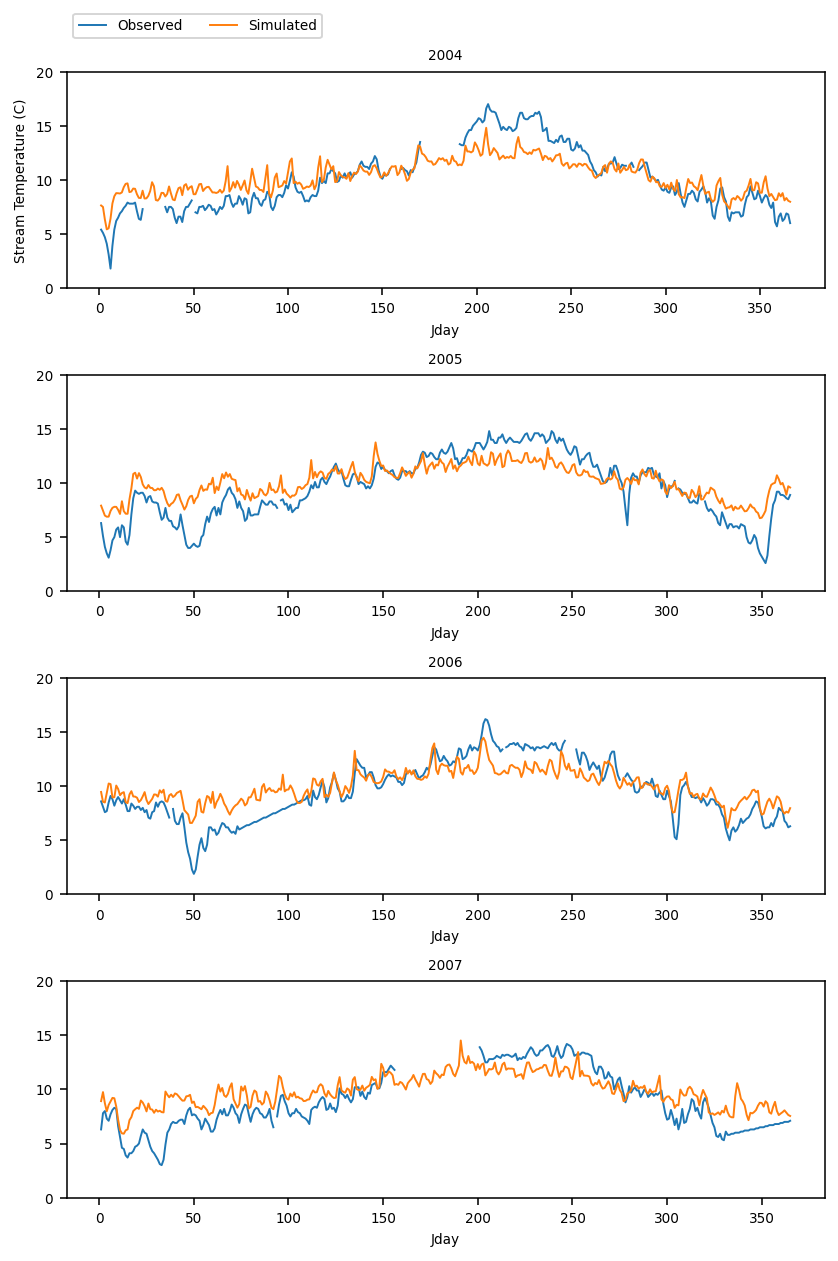

In [6]:
# Observed vs. simulated stream temp for gauge
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    streamtemp_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 20])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Stream Temperature (C)')
plt.tight_layout()

## Metrics

In [7]:
streamtemps = pd.concat([streamtemp_obs.loc[:, 'water_temp'], 
                         cell_results[0].loc[:, 'Water_Surface_Temperature(degrees_C)']], axis=1).dropna()

display('RMSE: ', np.sqrt(mean_squared_error(streamtemps.iloc[:, 0], streamtemps.iloc[:, 1])))
display('MAE: ', mean_absolute_error(streamtemps.iloc[:, 0], streamtemps.iloc[:, 1]))
display('R-squared: ', r2_score(streamtemps.iloc[:, 0], streamtemps.iloc[:, 1]))

'RMSE: '

1.7321003229348717

'MAE: '

1.417404336510264

'R-squared: '

0.6412186618784645

## Applying a correction factor to the simulated stream temp, which overpredicts temp, especially in winter

In [8]:
# Convert day of year to signal
day = 24 * 60 * 60
year = 365.2425 * day
df = streamtemps.copy()
timestamp_secs = pd.to_datetime(df.index)
timestamp_secs = timestamp_secs.map(datetime.datetime.timestamp)
df['year_cos'] = np.cos(timestamp_secs * (2 * np.pi / year))
df['year_sin'] = np.sin(timestamp_secs * (2 * np.pi / year))
# df['air temp'] = temp['temp']
df['air_temp_3day_avg'] = temp['temp'].rolling(3, min_periods=0).mean()

In [9]:
X = df.copy()
y = X.pop('water_temp')
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = sm.add_constant(X_train)
olsmodel = sm.OLS(y_train, X_train).fit()
print(olsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:             water_temp   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3159.
Date:                Sat, 01 May 2021   Prob (F-statistic):               0.00
Time:                        11:46:48   Log-Likelihood:                -1028.7
No. Observations:                 913   AIC:                             2067.
Df Residuals:                     908   BIC:                             2092.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [10]:
y_pred = olsmodel.predict(X_test)

# Test metrics
display('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
display('MAE: ', mean_absolute_error(y_test, y_pred))
display('R-squared: ', r2_score(y_test, y_pred))

y_corrected_sm = olsmodel.predict(X)

cols = X.columns.tolist()
cols.insert(0, 'water_temp_corrected')
streamtemp_sim_corrected_sm = pd.DataFrame(np.column_stack([y_corrected_sm, X]), columns=cols, index=streamtemps.index)
corrected_piv_sm = pd.pivot_table(streamtemp_sim_corrected_sm, index=streamtemp_sim_corrected_sm.index.dayofyear, 
                                  columns=streamtemp_sim_corrected_sm.index.year, 
                                  values='water_temp_corrected', dropna=False)

'RMSE: '

0.7559840340097924

'MAE: '

0.5785750075531806

'R-squared: '

0.9323668569408797

In [11]:
# Calculate confidence intervals

ci_values95 = olsmodel.conf_int(alpha=0.05, cols=None)
ci_lower95 = (X * ci_values95.iloc[:, 0].tolist()).sum(axis=1)
ci_lower95.name = 'ci_lower95'
ci_upper95 = (X * ci_values95.iloc[:, 1].tolist()).sum(axis=1)
ci_upper95.name = 'ci_upper95'

ci_values99 = olsmodel.conf_int(alpha=0.01, cols=None)
ci_lower99 = (X * ci_values99.iloc[:, 0].tolist()).sum(axis=1)
ci_lower99.name = 'ci_lower99'
ci_upper99 = (X * ci_values99.iloc[:, 1].tolist()).sum(axis=1)
ci_upper99.name = 'ci_upper99'

data_ci = pd.concat([X, y, ci_lower95, ci_upper95, ci_lower99, ci_upper99, streamtemp_sim_corrected_sm.loc[:, 'water_temp_corrected']],
                    axis=1)

ci_lower_yearly95 = pd.pivot_table(data_ci, index=data_ci.index.dayofyear, columns=data_ci.index.year, 
                         values='ci_lower95', dropna=False)
ci_upper_yearly95 = pd.pivot_table(data_ci, index=data_ci.index.dayofyear, columns=data_ci.index.year, 
                         values='ci_upper95', dropna=False)
ci_lower_yearly99 = pd.pivot_table(data_ci, index=data_ci.index.dayofyear, columns=data_ci.index.year, 
                         values='ci_lower99', dropna=False)
ci_upper_yearly99 = pd.pivot_table(data_ci, index=data_ci.index.dayofyear, columns=data_ci.index.year, 
                         values='ci_upper99', dropna=False)

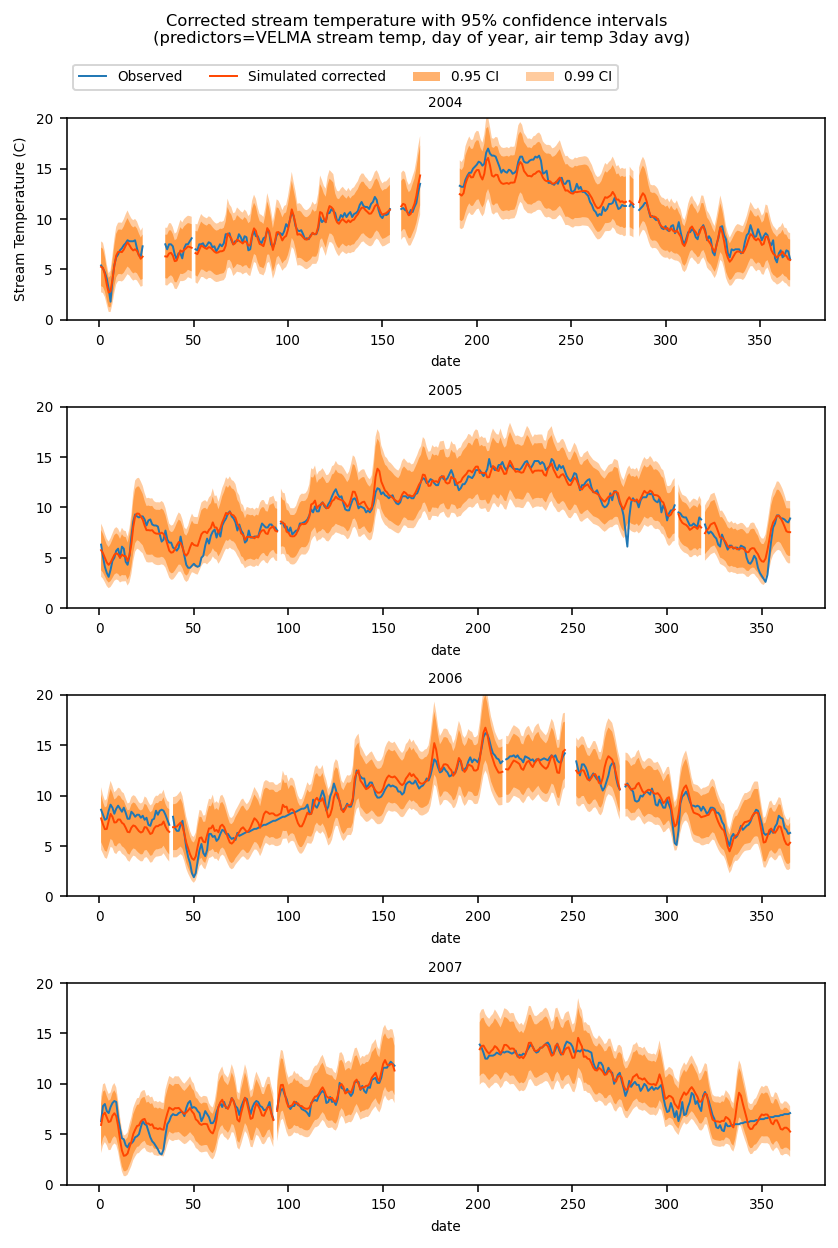

In [12]:
# Observed vs. simulated (corrected) stream temp for gauge, with CI
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', color='tab:blue', linewidth=1)
    corrected_piv_sm.iloc[:, col].plot(ax=axes[col], label='Simulated corrected', color='orangered', linewidth=1)
    axes[col].fill_between(ci_lower_yearly95.index, 
                           ci_lower_yearly95.iloc[:, col],
                           ci_upper_yearly95.iloc[:, col], color='tab:orange', alpha=0.6, label='0.95 CI', edgecolor=None)
    axes[col].fill_between(ci_lower_yearly99.index, 
                           ci_lower_yearly99.iloc[:, col],
                           ci_upper_yearly99.iloc[:, col], color='tab:orange', alpha=0.4, label='0.99 CI', edgecolor=None)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 20])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=4)
axes[0].set_ylabel('Stream Temperature (C)')
plt.suptitle('Corrected stream temperature with 95% confidence intervals \n (predictors=VELMA stream temp, day of year, air temp 3day avg)')
plt.tight_layout(rect=[0, 0, 1, 0.99])

#### Removing air temp 3 day avg as a feature - yields tighter confidence bounds but also smaller R-squared

In [13]:
df2 = df.drop('air_temp_3day_avg', axis=1)
X = df2.copy()
y = X.pop('water_temp')
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = sm.add_constant(X_train)
olsmodel_2 = sm.OLS(y_train, X_train).fit()

y_corrected_sm2 = olsmodel_2.predict(X)

cols = X.columns.tolist()
cols.insert(0, 'water_temp_corrected')
streamtemp_sim_corrected_sm2 = pd.DataFrame(np.column_stack([y_corrected_sm2, X]), columns=cols, index=streamtemps.index)
corrected_piv_sm2 = pd.pivot_table(streamtemp_sim_corrected_sm2, index=streamtemp_sim_corrected_sm2.index.dayofyear, 
                                  columns=streamtemp_sim_corrected_sm2.index.year, 
                                  values='water_temp_corrected', dropna=False)

In [14]:
# Calculate confidence intervals

ci_values95 = olsmodel_2.conf_int(alpha=0.05, cols=None)
ci_lower95 = (X * ci_values95.iloc[:, 0].tolist()).sum(axis=1)
ci_lower95.name = 'ci_lower95'
ci_upper95 = (X * ci_values95.iloc[:, 1].tolist()).sum(axis=1)
ci_upper95.name = 'ci_upper95'

ci_values99 = olsmodel_2.conf_int(alpha=0.01, cols=None)
ci_lower99 = (X * ci_values99.iloc[:, 0].tolist()).sum(axis=1)
ci_lower99.name = 'ci_lower99'
ci_upper99 = (X * ci_values99.iloc[:, 1].tolist()).sum(axis=1)
ci_upper99.name = 'ci_upper99'

data_ci_2 = pd.concat([X, y, ci_lower95, ci_upper95, ci_lower99, ci_upper99, streamtemp_sim_corrected_sm2.loc[:, 'water_temp_corrected']],
                    axis=1)

ci_lower_yearly95_2 = pd.pivot_table(data_ci_2, index=data_ci_2.index.dayofyear, columns=data_ci_2.index.year, 
                         values='ci_lower95', dropna=False)
ci_upper_yearly95_2 = pd.pivot_table(data_ci_2, index=data_ci_2.index.dayofyear, columns=data_ci_2.index.year, 
                         values='ci_upper95', dropna=False)
ci_lower_yearly99_2 = pd.pivot_table(data_ci_2, index=data_ci_2.index.dayofyear, columns=data_ci_2.index.year, 
                         values='ci_lower99', dropna=False)
ci_upper_yearly99_2 = pd.pivot_table(data_ci_2, index=data_ci_2.index.dayofyear, columns=data_ci_2.index.year, 
                         values='ci_upper99', dropna=False)

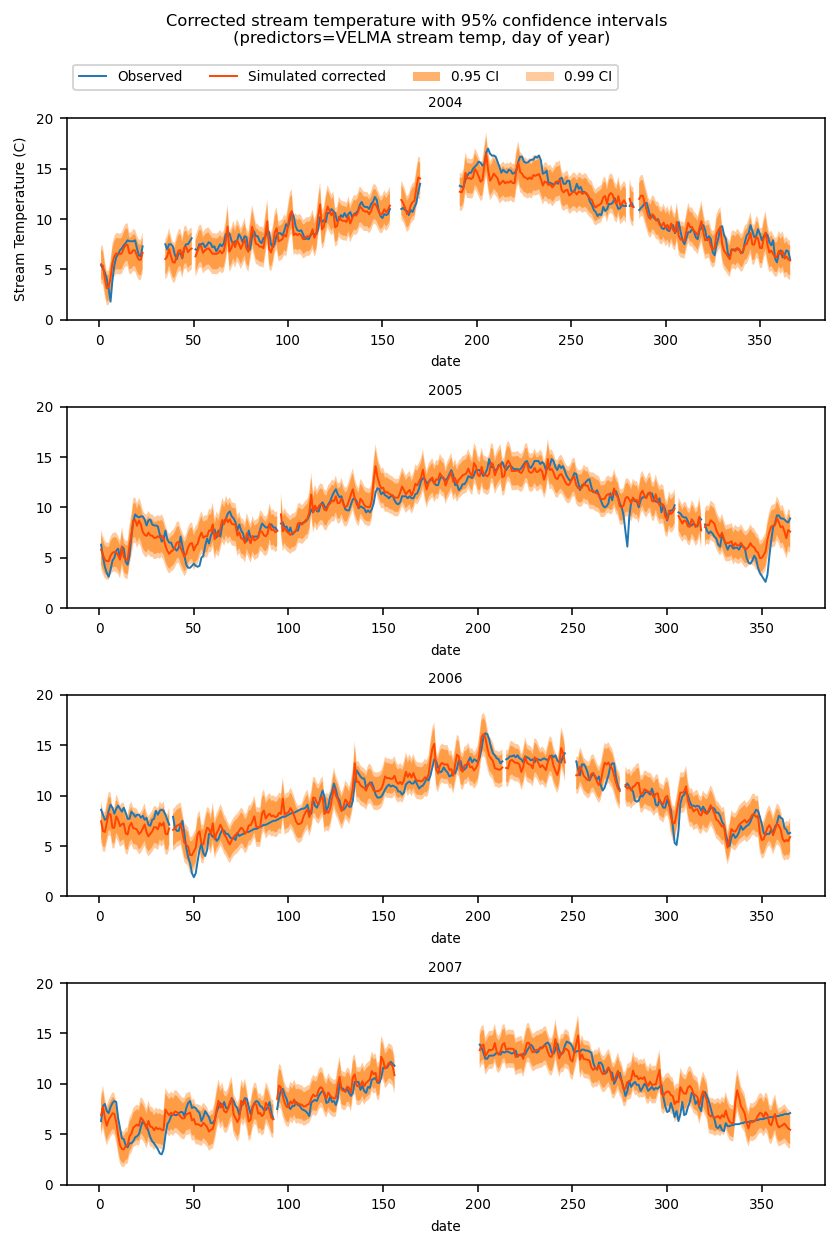

In [15]:
# Observed vs. simulated (corrected) stream temp for gauge, with CI
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', color='tab:blue', linewidth=1)
    corrected_piv_sm2.iloc[:, col].plot(ax=axes[col], label='Simulated corrected', color='orangered', linewidth=1)
    axes[col].fill_between(ci_lower_yearly95_2.index, 
                           ci_lower_yearly95_2.iloc[:, col],
                           ci_upper_yearly95_2.iloc[:, col], color='tab:orange', alpha=0.6, label='0.95 CI', edgecolor=None)
    axes[col].fill_between(ci_lower_yearly99_2.index, 
                           ci_lower_yearly99_2.iloc[:, col],
                           ci_upper_yearly99_2.iloc[:, col], color='tab:orange', alpha=0.4, label='0.99 CI', edgecolor=None)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 20])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=4)
axes[0].set_ylabel('Stream Temperature (C)')
plt.suptitle('Corrected stream temperature with 95% confidence intervals \n (predictors=VELMA stream temp, day of year)')
plt.tight_layout(rect=[0, 0, 1, 0.99])

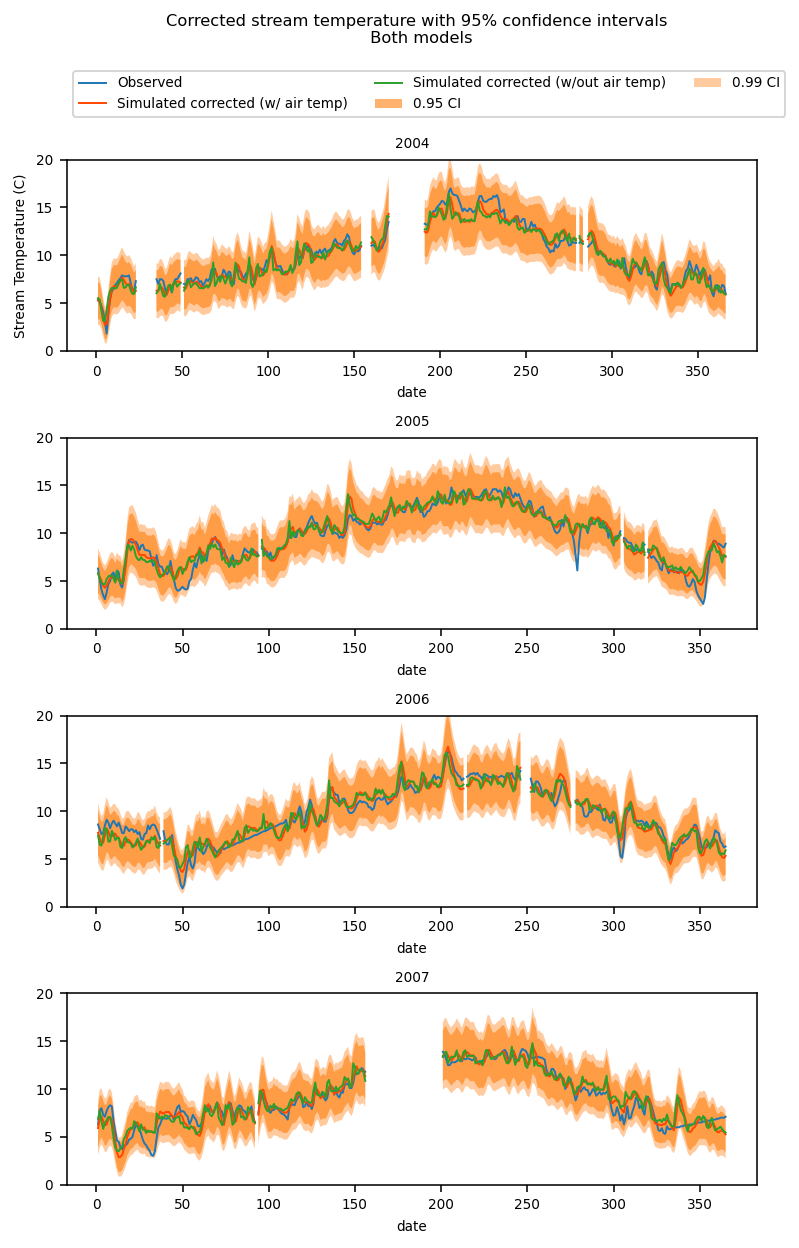

In [16]:
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', color='tab:blue', linewidth=1)
    corrected_piv_sm.iloc[:, col].plot(ax=axes[col], label='Simulated corrected (w/ air temp)', color='orangered', linewidth=1)
    corrected_piv_sm2.iloc[:, col].plot(ax=axes[col], label='Simulated corrected (w/out air temp)', color='tab:green', linewidth=1)
    axes[col].fill_between(ci_lower_yearly95.index, 
                           ci_lower_yearly95.iloc[:, col],
                           ci_upper_yearly95.iloc[:, col], color='tab:orange', alpha=0.6, label='0.95 CI', edgecolor=None)
    axes[col].fill_between(ci_lower_yearly99.index, 
                           ci_lower_yearly99.iloc[:, col],
                           ci_upper_yearly99.iloc[:, col], color='tab:orange', alpha=0.4, label='0.99 CI', edgecolor=None)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 20])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.5), fancybox=True, ncol=3)
axes[0].set_ylabel('Stream Temperature (C)')
plt.suptitle('Corrected stream temperature with 95% confidence intervals \n Both models')
plt.tight_layout(rect=[0, 0, 1, 0.99])

## Stream temp and air temp

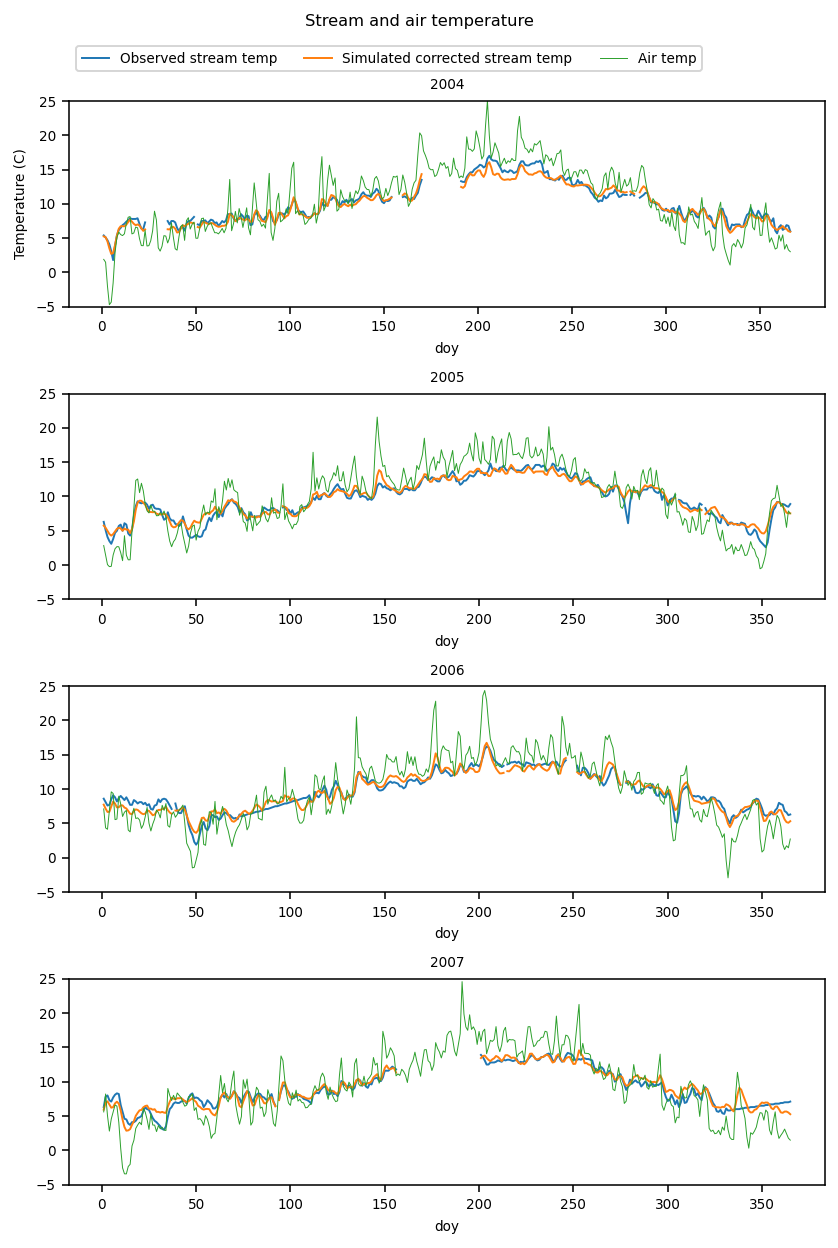

In [17]:
temp_yearly = pd.pivot_table(temp, index='doy', columns='year', values='temp', dropna=False)

# Observed stream temp vs air temp
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed stream temp', linewidth=1)
    corrected_piv_sm.iloc[:, col].plot(ax=axes[col], label='Simulated corrected stream temp', linewidth=1)
    temp_yearly.iloc[:, col].plot(ax=axes[col], label='Air temp', linewidth=0.5)
    axes[col].set_title(year)
    axes[col].set_ylim([-5, 25])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=3)
axes[0].set_ylabel('Temperature (C)')
plt.suptitle('Stream and air temperature')
plt.tight_layout(rect=[0, 0, 1, 0.99])

## Stream temp and quality flags

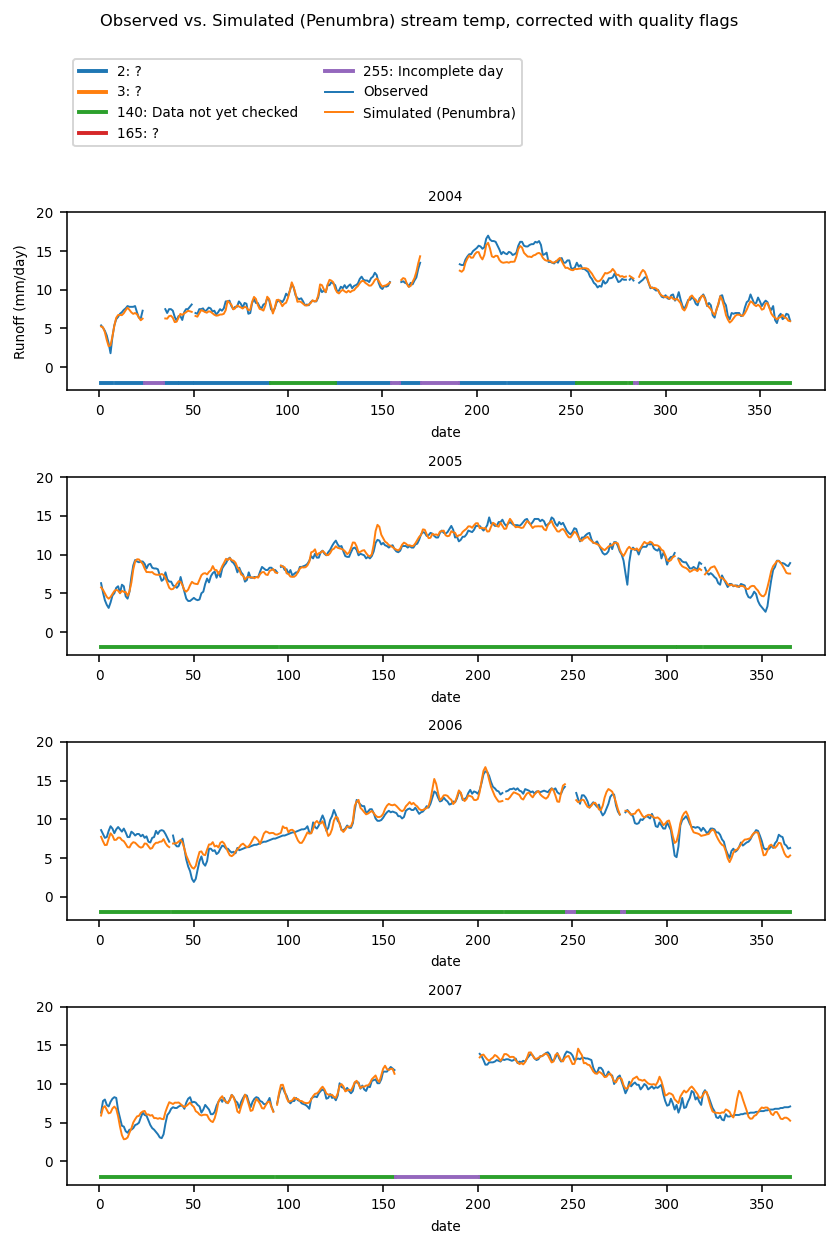

In [18]:
# Add quality scores below plot

colors = sns.color_palette('tab10', 10)

stream_temp_quality_yearly = pd.pivot_table(stream_temp_quality, index='doy', columns='year', values='quality', dropna=False)

quality2 = stream_temp_quality_yearly.replace([2, 3, 140, 165, 255],
                                        [-2, np.nan, np.nan, np.nan, np.nan])
quality3 = stream_temp_quality_yearly.replace([2, 3, 140, 165, 255],
                                        [np.nan, -2, np.nan, np.nan, np.nan])
quality140 = stream_temp_quality_yearly.replace([2, 3, 140, 165, 255],
                                        [np.nan, np.nan, -2, np.nan, np.nan])
quality165 = stream_temp_quality_yearly.replace([2, 3, 140, 165, 255],
                                         [np.nan, np.nan, np.nan, -2, np.nan])
quality255 = stream_temp_quality_yearly.replace([2, 3, 140, 165, 255],
                                        [np.nan, np.nan, np.nan, np.nan, -2])

years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
#     ax2 = axes[col].twinx()
#     precip_yearly.iloc[:, col].plot(ax=ax2, label='Precip', color='tab:green', linewidth=0.5)
#     if col == 0:
#         ax2.set_ylabel('Precipitation (mm/day)')
#         ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    quality2.iloc[:, col].plot(ax=axes[col], color=colors[0], linewidth=2, label='2: ?')
    quality3.iloc[:, col].plot(ax=axes[col], color=colors[1], linewidth=2, label='3: ?')
    quality140.iloc[:, col].plot(ax=axes[col], color=colors[2], linewidth=2, label='140: Data not yet checked')
    quality165.iloc[:, col].plot(ax=axes[col], color=colors[3], linewidth=2, label='165: ?')
    quality255.iloc[:, col].plot(ax=axes[col], color=colors[4], linewidth=2, label='255: Incomplete day')
    streamtemp_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    corrected_piv_sm.iloc[:, col].plot(ax=axes[col], label='Simulated (Penumbra)', linewidth=1)
#     ax2.invert_yaxis()
    axes[col].set_ylim([-3, 20])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.9), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Observed vs. Simulated (Penumbra) stream temp, corrected with quality flags')
plt.tight_layout()
# plt.savefig('baseline_runoffs_qaflags.png', dpi=300)



140 - Data not yet checked
255 - Incomplete day
